# cygnus-dram-bandwidth
Evaluate prefetchers on systems with different DRAM bandwidth.

In [23]:
from collections import defaultdict
from importlib import reload

from matplotlib import colormaps
from matplotlib import pyplot as plt
import numpy as np
from utils import plots, stats, tables, utils

# Configuration

In [24]:
base_dir = '/u/cmolder/GitHub/ChampSim/out/cygnus/'
suites = [
    #('spec06', 'one_phase'),
    ('spec06', 'weighted'),
    ('spec17', 'weighted'),
    ('cloudsuite', 'weighted'),
    ('gap', 'one_phase'),
    ('google', 'one_phase')
]
metrics  = [
    'ipc_improvement',
]
features = [
    {'Delta_Path', 'PC_Delta'}
]
baselines = [
    'bingo', 'spp_dev2', 'spp_ppf_dev', 'mlop', 'dspatch', 'sms'
]
dram_bws = [300, 1200, 6400]
default_dram_bw = 1200
dpi = 192

In [25]:
dfs = {}
for bw in dram_bws:
    name = f'{bw}mtps_degreedyn'
    real_name = f'{bw}mtps_degreedyn' if bw != default_dram_bw else 'degreedyn'

    dfs[f'{name}/baseline'] = tables.load_stats_csv(
        base_dir, f'{real_name}/baseline.csv',
        baselines, prefetchers_level='l2')
    
    dfs[f'{name}/bo/dynwidth/score16_fallback'] = tables.load_stats_csv(
        base_dir, f'{real_name}/bo/dynwidth/score16_fallback.csv',
        ['bo'], prefetchers_level='l2')
    
    dfs[f'{name}/pythia/bwaware3'] = tables.load_stats_csv_pythia(
        base_dir, f'{real_name}/pythia/bwaware3.csv',
        features, feature_key='pythia_features')

    # dfs[f'{name}/cygnus/bwaware3_width_moreactions_real'] = tables.load_stats_csv_pythia(
    #     base_dir, f'{real_name}/cygnus/bwaware3_width_moreactions_real.csv',
    #     features, feature_key='cygnus_features')
    
    # TODO
    dfs[f'{name}/cygnus/bwaware3_width_moreactions_real_actionprio'] = tables.load_stats_csv_pythia(
        base_dir, f'{real_name}/cygnus/bwaware3_width_moreactions_real_actionprio.csv',
        features, feature_key='cygnus_features')

# Plotting arguments
colors = defaultdict(lambda: None, {
    'Cygnus':       colormaps['Set3'](0), #cmaps['Cygnus-Width'](0.65),
    'Cygnus Depth': colormaps['Set3'](1), #cmaps['Cygnus-Ignore'](0.65),

    'Pythia':       colormaps['Set3'](2), #cmaps['Pythia'](0.65),
    #'Pythia +Ignore':                    #cmaps['Pythia-Ignore'](0.65),
    #'Pythia Width':                      #cmaps['Pythia-Width'](0.5),

    'Bingo':    colormaps['Set3'](3), #'purple',
    'SMS':      colormaps['Set3'](4), #'royalblue',
    'SPP':      colormaps['Set3'](5), #'royalblue',
    'SPP+PPF':  colormaps['Set3'](6), #'darkturquoise',
    'MLOP':     colormaps['Set3'](7), #'deeppink',
    'DSPatch':  colormaps['Set3'](8), #'darkred',
    'BO-Width': colormaps['Set3'](9), #'gold',
})

# Plots

## Helper functions

In [26]:
def plot_dram_bws(data_df, suite='spec06', metric='ipc_improvement',
                  colors=defaultdict(lambda: None), 
                  linestyles=defaultdict(lambda: None),
                  markers=defaultdict(lambda: None),
                  legend_kwargs={}, 
                  dpi=None, figsize=None,
                  ylabel=None, ymin=None, ymax=None,
                  suptitle=""):
    
    # for k, v in data_df.items():
    #     print(k)
    #     display(v)
    # assert(suite in suites)
    table = tables.gen_table_metric_all(data_df, suites, metric)

    table['Scheme'] = table.index.to_series()
    table['Scheme'] =  table['Scheme'].apply(lambda x: ' '.join(x.split(' ')[:-2]))
    table['Bandwidth'] = table.index.to_series()
    table['Bandwidth'] =  table['Bandwidth'].apply(lambda x: x.split(' ')[-2])
    # display(table)

    # Plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    X = np.arange(0, len(table['Bandwidth'].unique()), 1)
    for scheme in table['Scheme'].unique():
        y = np.zeros(len(X))
        for i, bw in enumerate(table['Bandwidth'].unique()):
            row = table.loc[(table['Scheme'] == scheme) & (table['Bandwidth'] == bw)]
            y[i] = row[suite].item()
        
        ax.plot(X, y, label=scheme, color=colors[scheme], 
                ls=linestyles[scheme], marker=markers[scheme])

    # Axes
    ax.set_xlabel('DRAM bandwidth (MT/s)')
    ax.set_xticks(np.arange(0, len(table['Bandwidth'].unique()), 1))
    ax.set_xticklabels(table['Bandwidth'].unique())
    ax.set_ylabel(metric if ylabel is None else ylabel)
    ax.set_ylim(ymin=ymin, ymax=ymax)
    

    # Legend
    ax.legend(**legend_kwargs)

    # Grid
    ax.grid(axis='both', color='lightgray')
    ax.set_axisbelow(True)

    # Title
    # fig.suptitle(f'{suite} {metric}')
    fig.tight_layout()
    plt.show()

## Overall

In [32]:
feature = 'Delta_Path, PC_Delta'

degreedyn_1core_df = {}

for bw in dram_bws:
    name = f'{bw}mtps_degreedyn'
    degreedyn_1core_df[f'Cygnus {bw} MT/s'] = dfs[f'{name}/cygnus/bwaware3_width_moreactions_real_actionprio'][feature]
    degreedyn_1core_df[f'Pythia {bw} MT/s'] = dfs[f'{name}/pythia/bwaware3'][feature]
    degreedyn_1core_df[f'Bingo {bw} MT/s'] = dfs[f'{name}/baseline']['bingo']
    # degreedyn_1core_df[f'SMS {bw} MT/s'] = dfs[f'{name}/baseline']['sms']
    degreedyn_1core_df[f'SPP {bw} MT/s'] = dfs[f'{name}/baseline']['spp_dev2']
    degreedyn_1core_df[f'SPP+PPF {bw} MT/s'] = dfs[f'{name}/baseline']['spp_ppf_dev']
    # degreedyn_1core_df[f'MLOP {bw} MT/s'] = dfs[f'{name}/baseline']['mlop']
    # degreedyn_1core_df[f'DSPatch {bw} MT/s'] = dfs[f'{name}/baseline']['dspatch']
    degreedyn_1core_df[f'BO-Width {bw} MT/s'] = dfs[f'{name}/bo/dynwidth/score16_fallback']['bo']

degreedyn_1core_legend_kwargs = {
    'ncol': 5,
    'loc': 'lower center',
    'bbox_to_anchor': (0.5, 1.0),
    'fontsize': 6.75,
    'frameon': False,
}

linestyles = defaultdict(lambda: '-', {
    # 'SPP+PPF': '-',
    # 'Pythia': '-',
    # 'Cygnus': '-',
})

markers = defaultdict(lambda: 'o', {
    # 'SPP+PPF': 'o',
    # 'Pythia': 'o',
    # 'Cygnus': 'o',
})

### IPC improvement

=== all ===


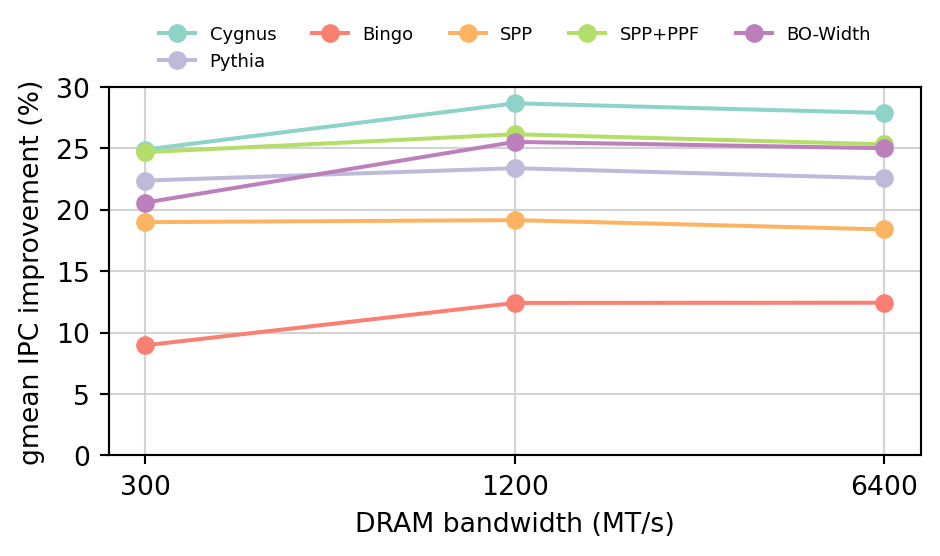

In [6]:
for suite, _ in [('all', None)]:# + suites:
    print(f'=== {suite} ===')
    plot_dram_bws(degreedyn_1core_df, suite=suite, metric='ipc_improvement', 
                  legend_kwargs=degreedyn_1core_legend_kwargs,
                  colors=colors, linestyles=linestyles, markers=markers,
                  dpi=192, figsize=(5, 3),
                  ylabel='gmean IPC improvement (%)', ymin=0, ymax=30)

### L2C accuracy

=== all ===


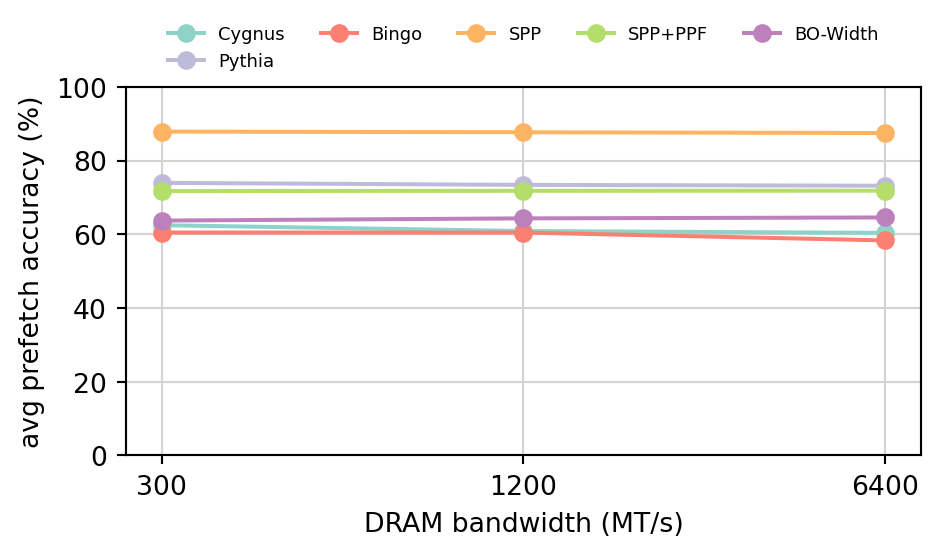

In [12]:
for suite, _ in [('all', None)]:# + suites:
    print(f'=== {suite} ===')
    plot_dram_bws(degreedyn_1core_df, suite=suite, metric='L2C_accuracy', 
                  legend_kwargs=degreedyn_1core_legend_kwargs,
                  colors=colors, linestyles=linestyles, markers=markers,
                  dpi=192, figsize=(5, 3),
                  ylabel='avg prefetch accuracy (%)', ymin=0, ymax=100)

### L2C coverage

=== all ===


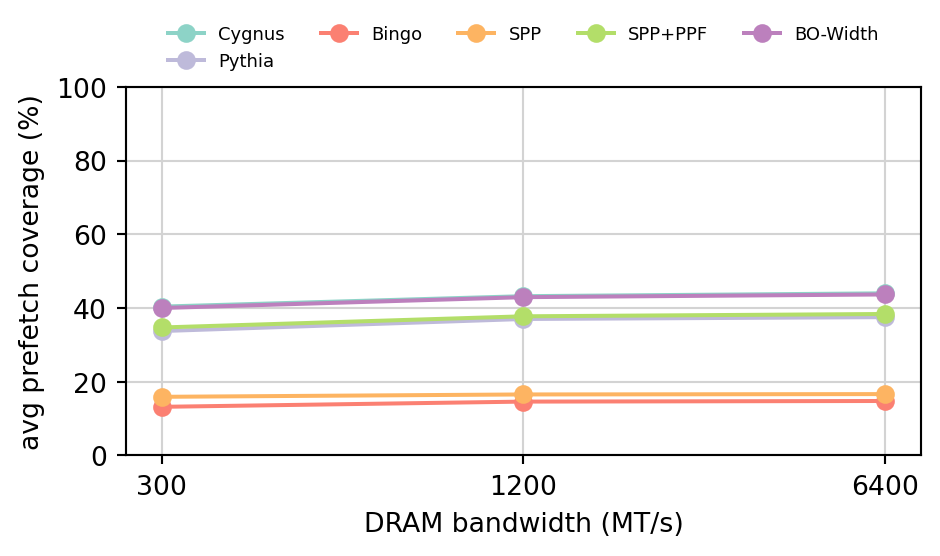

In [11]:
for suite, _ in [('all', None)]:# + suites:
    print(f'=== {suite} ===')
    plot_dram_bws(degreedyn_1core_df, suite=suite, metric='L2C_coverage', 
                  legend_kwargs=degreedyn_1core_legend_kwargs,
                  colors=colors, linestyles=linestyles, markers=markers,
                  dpi=192, figsize=(5, 3),
                  ylabel='avg prefetch coverage (%)', ymin=0, ymax=100)

### LLC avg. miss cycles

=== all ===


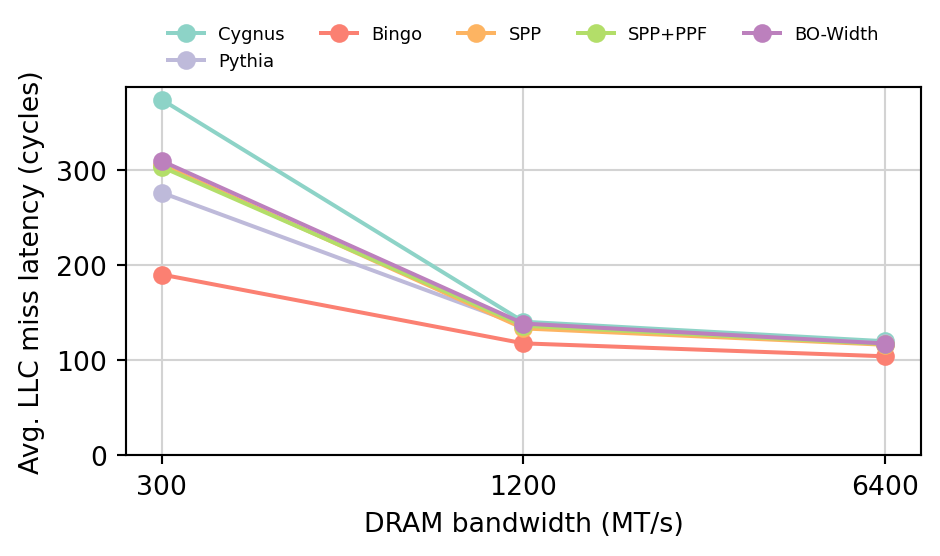

In [33]:
for suite, _ in [('all', None)]:# + suites:
    print(f'=== {suite} ===')
    plot_dram_bws(degreedyn_1core_df, suite=suite, metric='LLC_miss_cycles_avg', 
                  legend_kwargs=degreedyn_1core_legend_kwargs,
                  colors=colors, linestyles=linestyles, markers=markers,
                  dpi=192, figsize=(5, 3),
                  ylabel='Avg. LLC miss latency (cycles)', ymin=0)

## Per-trace

In [27]:
feature = 'Delta_Path, PC_Delta'
bw_df = {}
bw_colors = {}

bw_paths = {
    'Pythia': 'pythia/bwaware3',
    'Cygnus': 'cygnus/bwaware3_width_moreactions_real_actionprio',
    'SPP+PPF': 'baseline',
}

bw_frames = {
    'Pythia': feature,
    'Cygnus': feature,
    'SPP+PPF': 'spp_ppf_dev',
}

for pref in ['Pythia', 'Cygnus', 'SPP+PPF']:
    for i, bw in enumerate(dram_bws):
        name = f'{bw}mtps_degreedyn'
        bw_df[f'{pref} {bw}'] = dfs[f'{name}/{bw_paths[pref]}'][bw_frames[pref]]
        bw_colors[f'{pref} {bw}'] = colors[pref]

bw_legend_kwargs = {
    'ncol': 3,
    'fontsize': 6,
    'loc': 'lower center',
    'bbox_to_anchor': (0.5, 1.0),
    'framealpha': 0.0,
}

bw_label_kwargs = {
    'rotation': 0,
    'ha': 'center',
    'fontsize': 7,
}

### IPC improvement

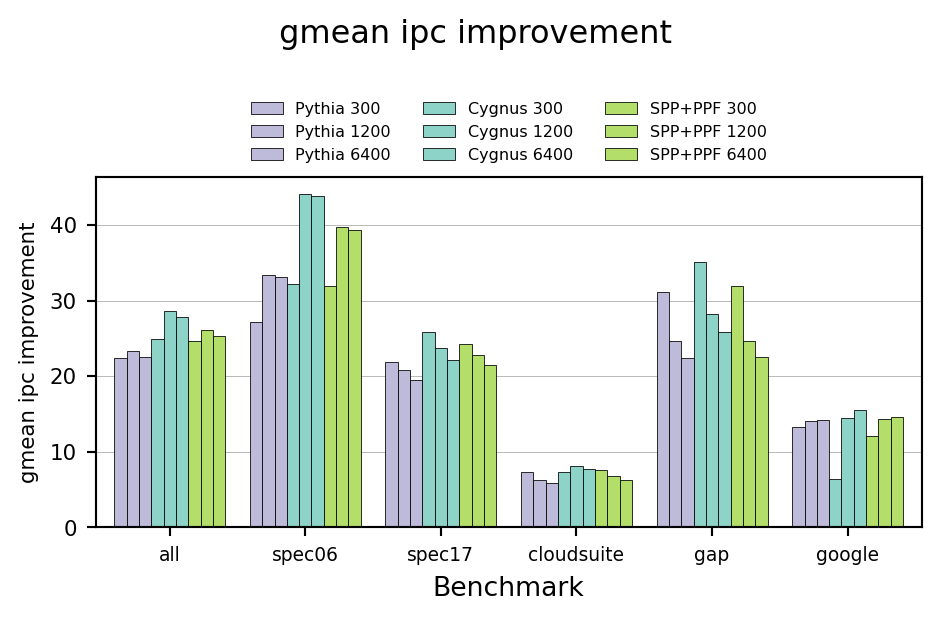

In [14]:
plots.plot_metric_means(bw_df, suites=suites, metric='ipc_improvement', 
                        colors=bw_colors, legend_kwargs=bw_legend_kwargs, 
                        label_kwargs=bw_label_kwargs,
                        dpi=192, figsize=(5, 3.25))

=== spec06 weighted ===
=== spec17 weighted ===
=== cloudsuite weighted ===
=== gap one_phase ===
=== google one_phase ===


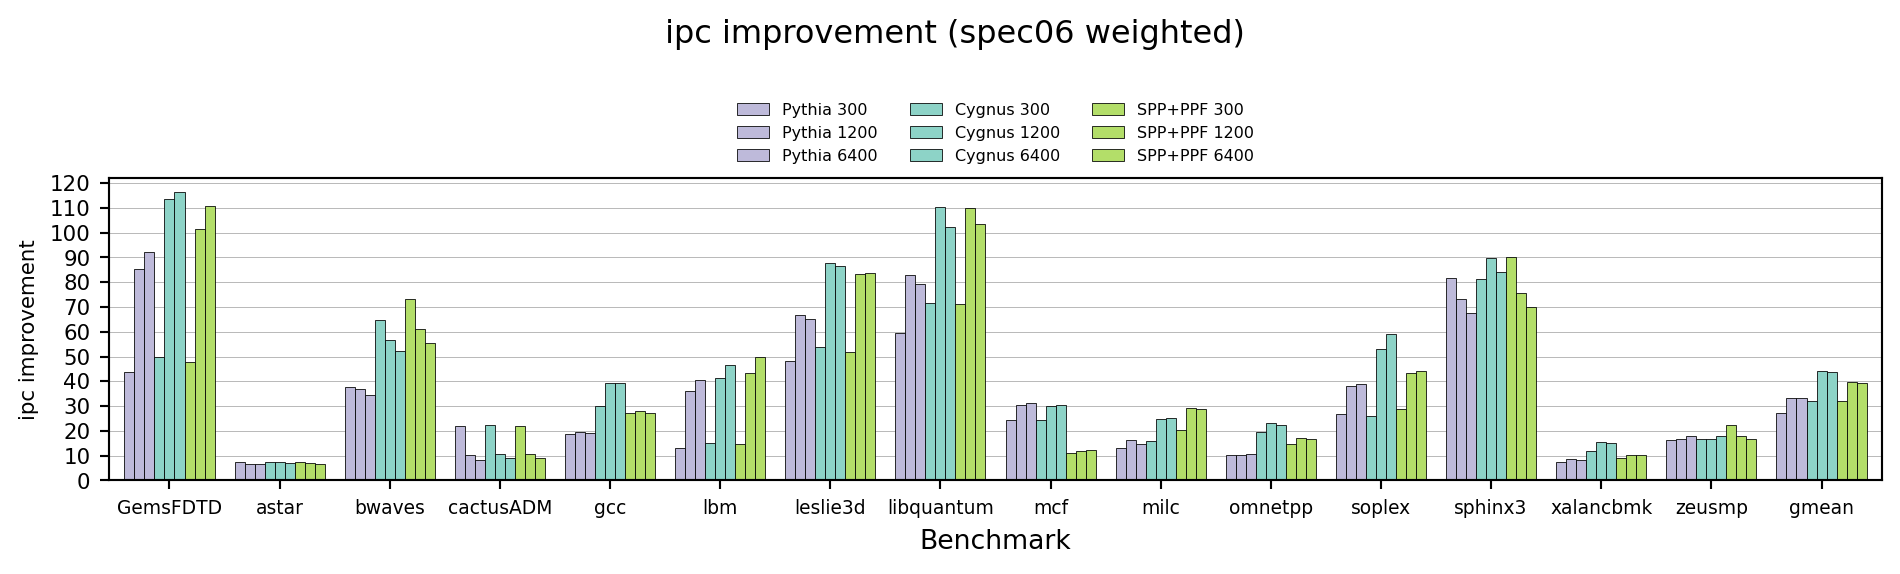

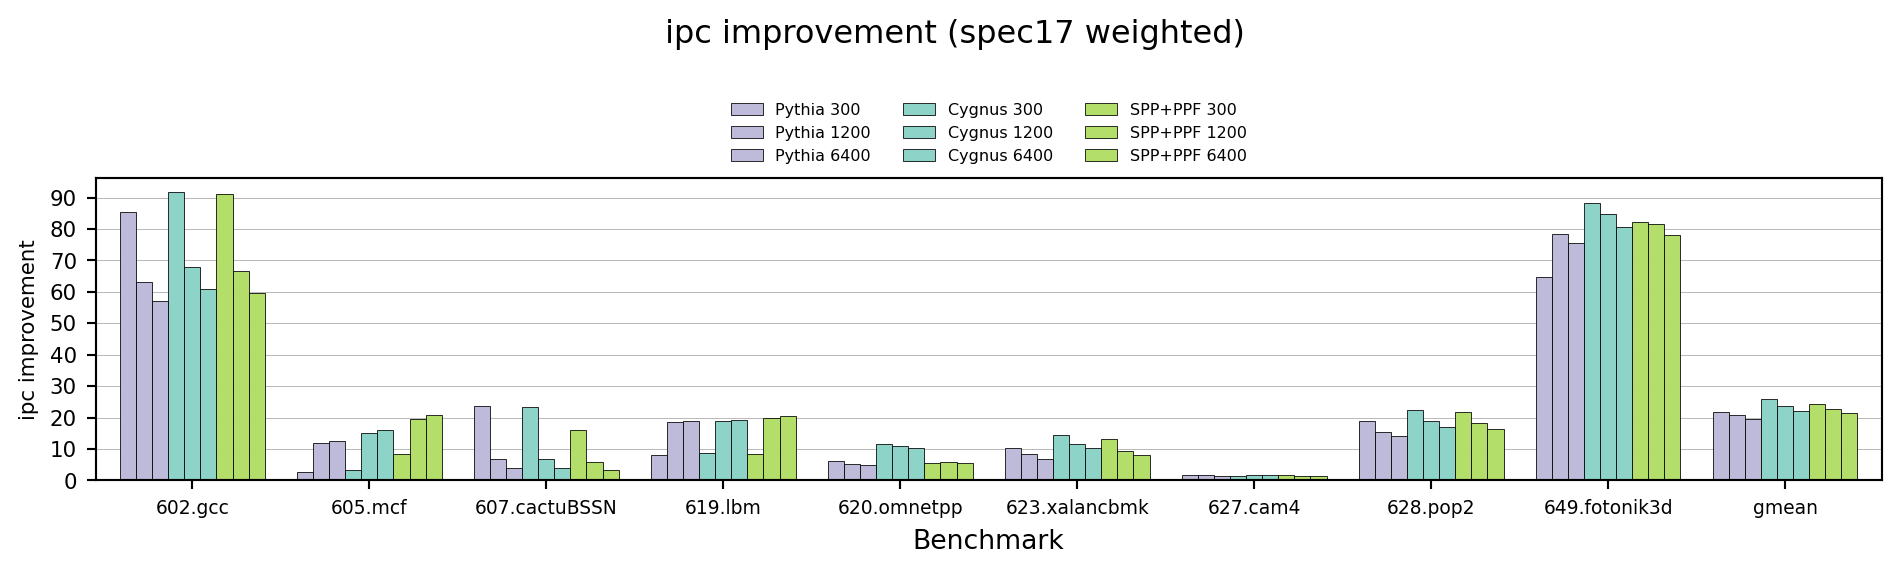

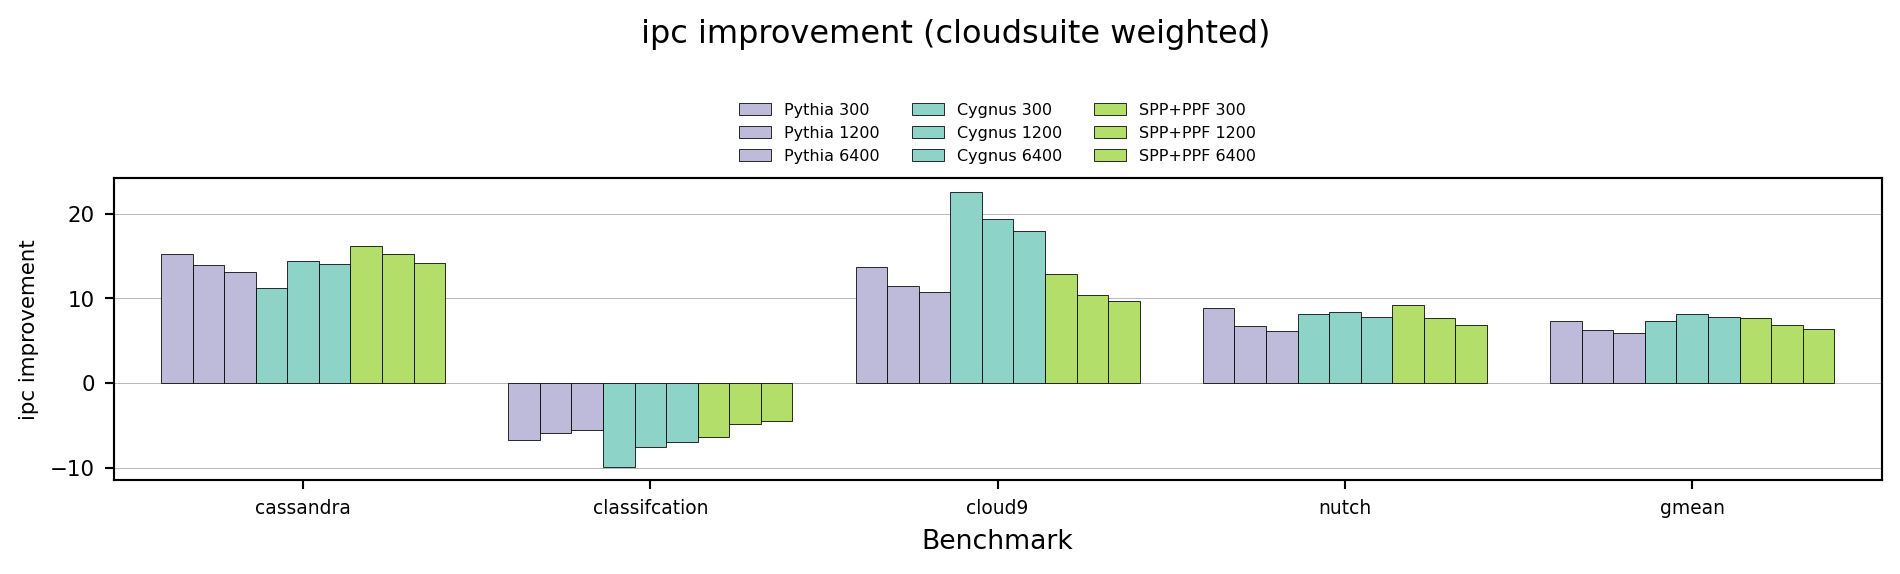

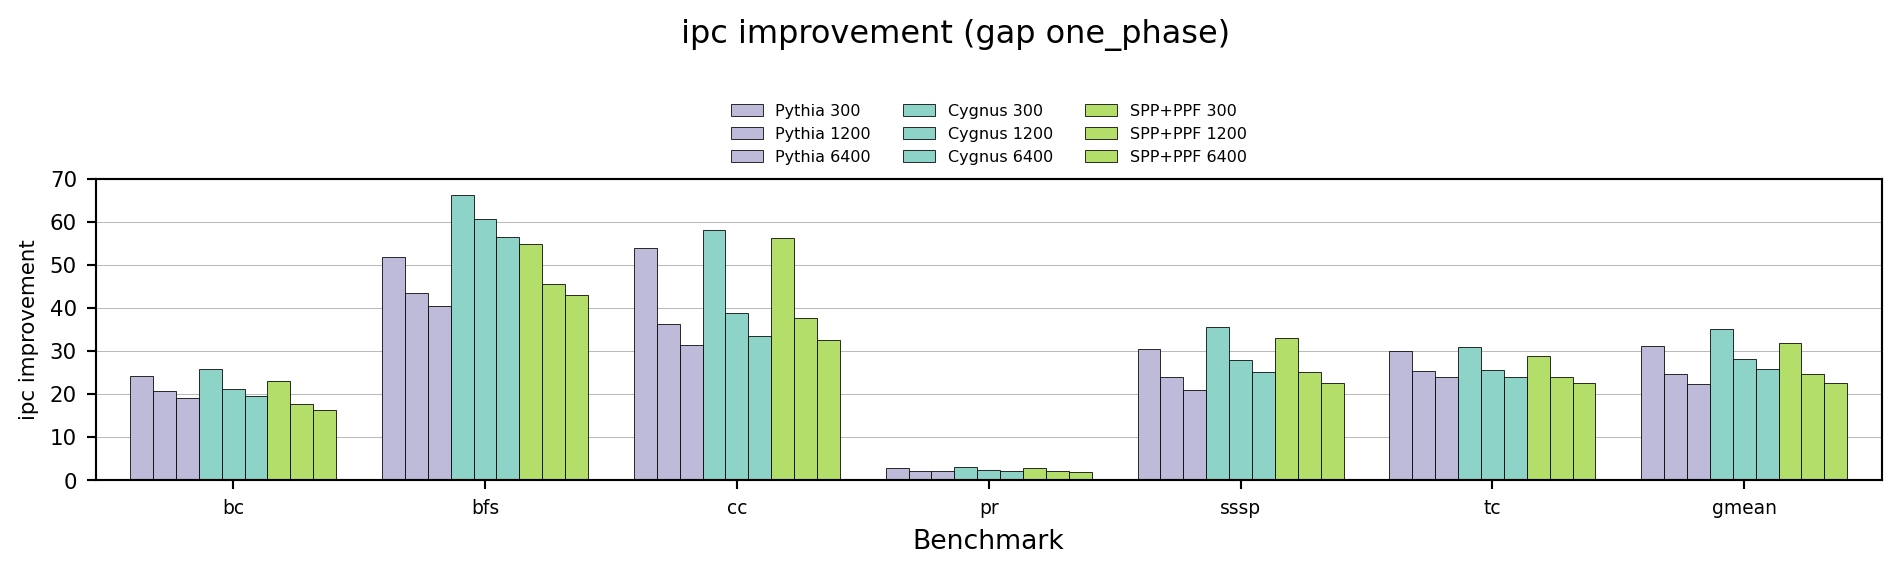

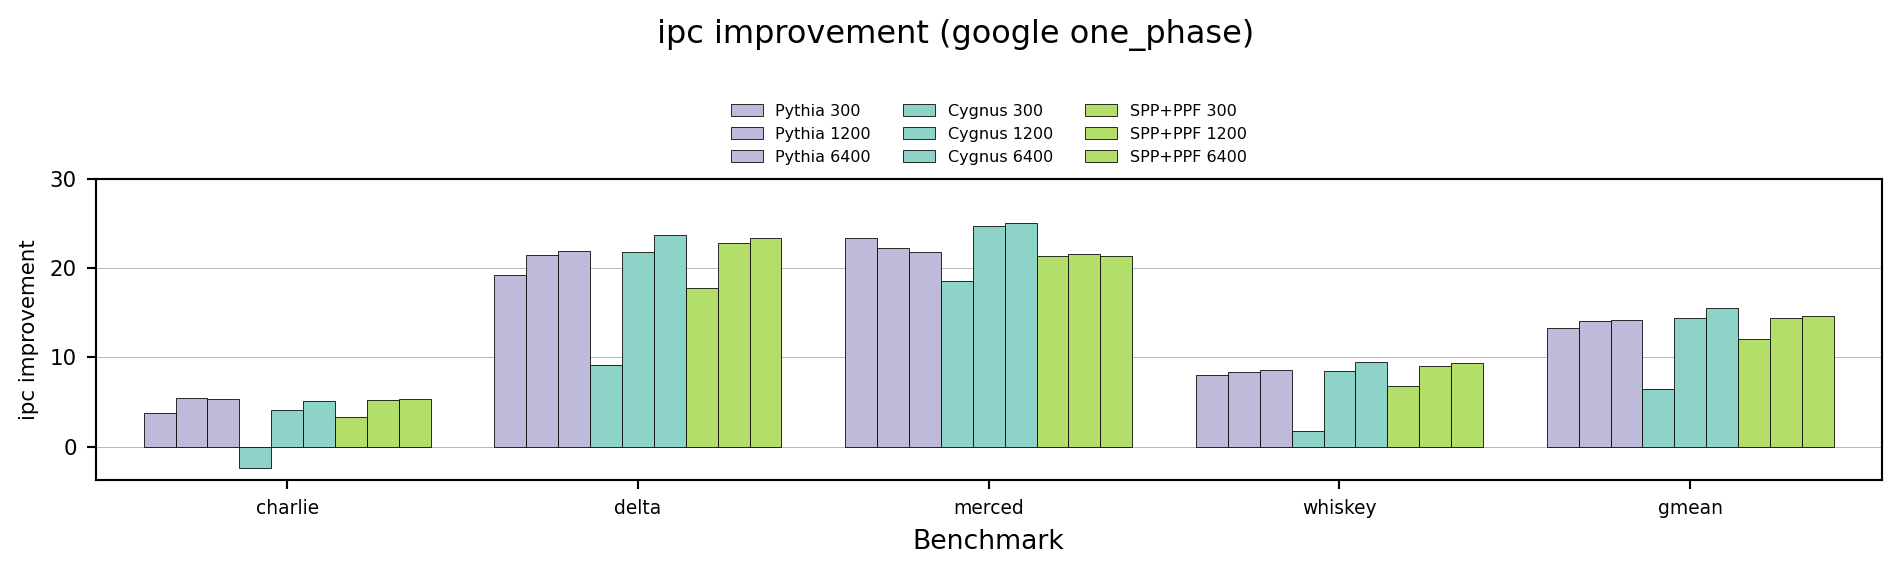

In [16]:
plots.plot_everything(bw_df, suites=suites, metrics=['ipc_improvement'], 
                      colors=bw_colors, legend_kwargs=bw_legend_kwargs,
                      label_kwargs=bw_label_kwargs, 
                      dpi=192, figsize=(10, 3))

### LLC avg. miss cycles

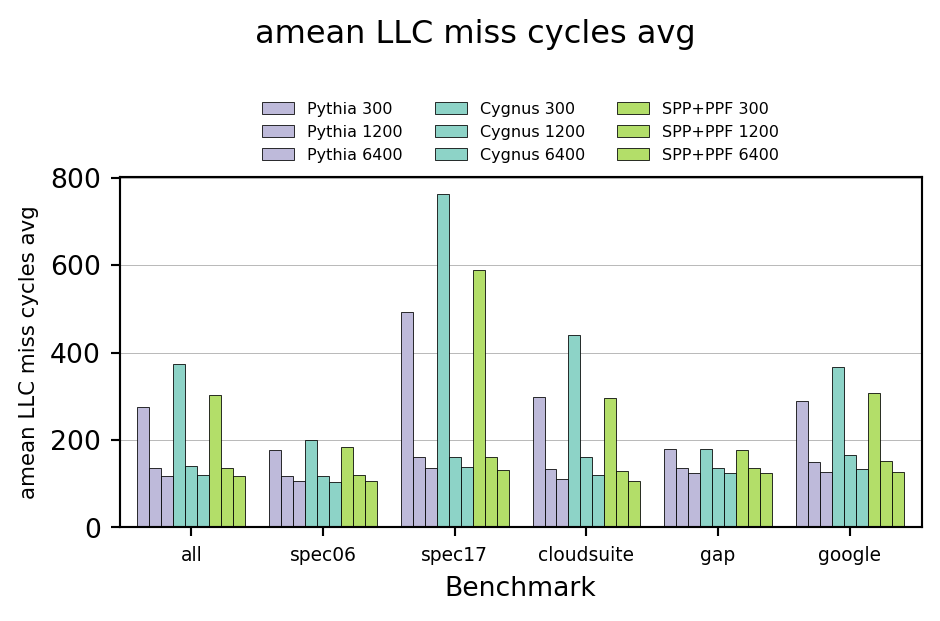

In [28]:
plots.plot_metric_means(bw_df, suites=suites, metric='LLC_miss_cycles_avg', 
                        colors=bw_colors, legend_kwargs=bw_legend_kwargs, 
                        label_kwargs=bw_label_kwargs,
                        dpi=192, figsize=(5, 3.25))

=== spec06 weighted ===
=== spec17 weighted ===
=== cloudsuite weighted ===
=== gap one_phase ===
=== google one_phase ===


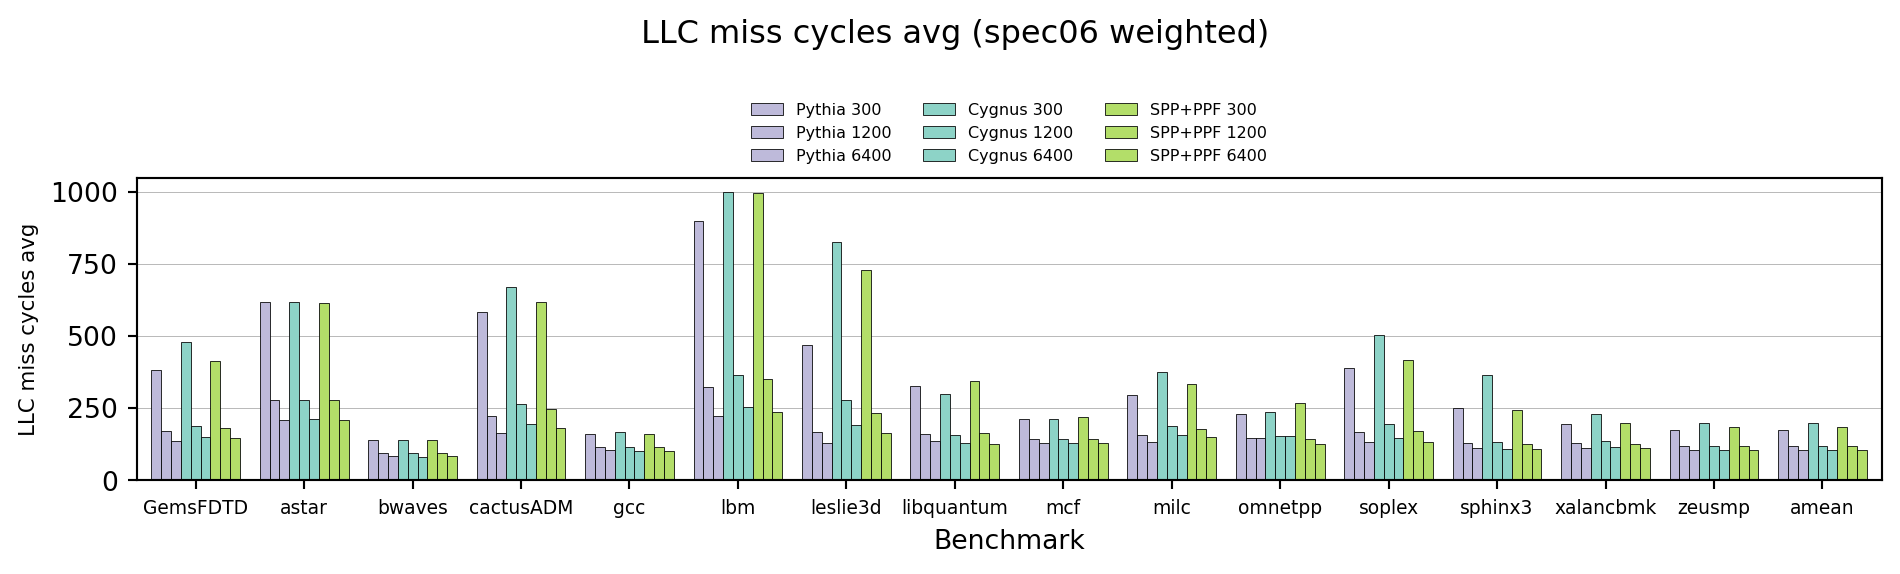

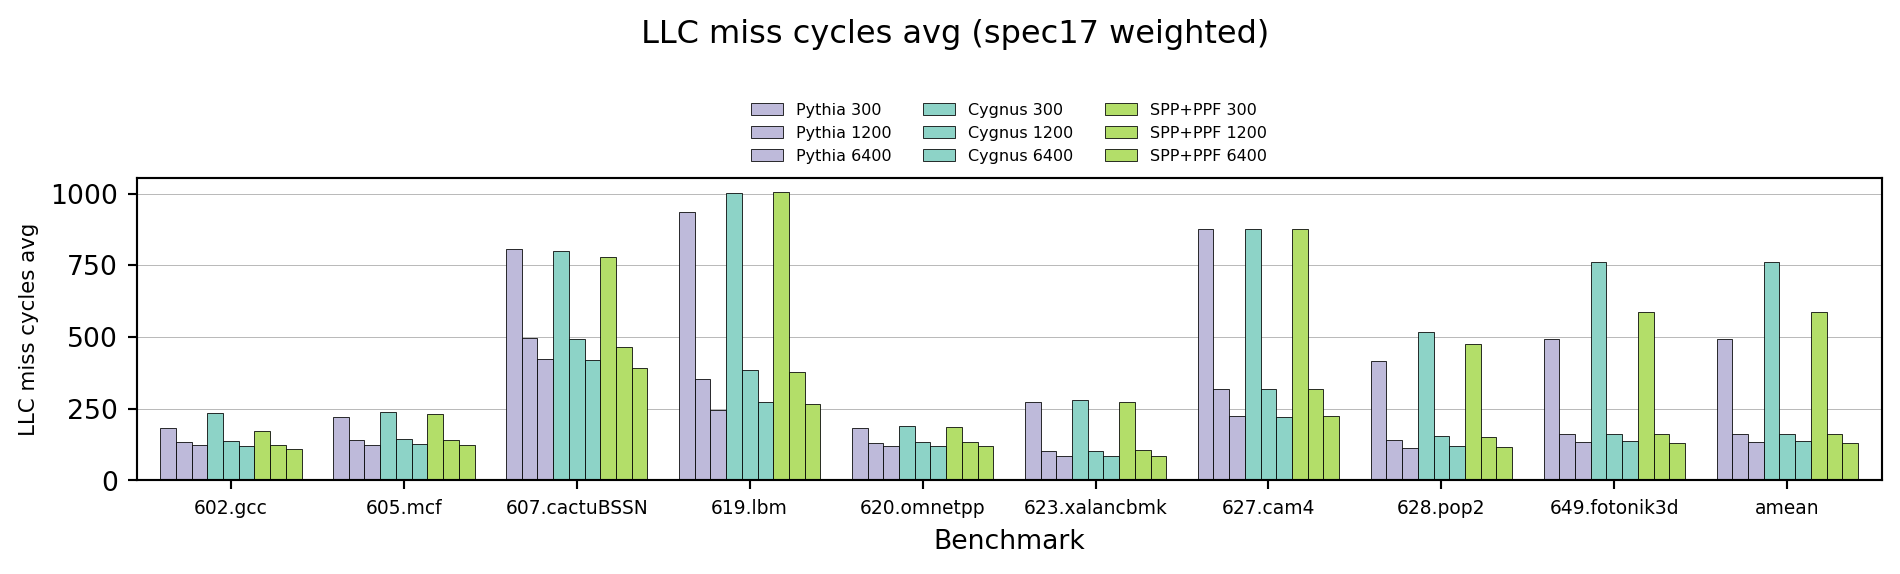

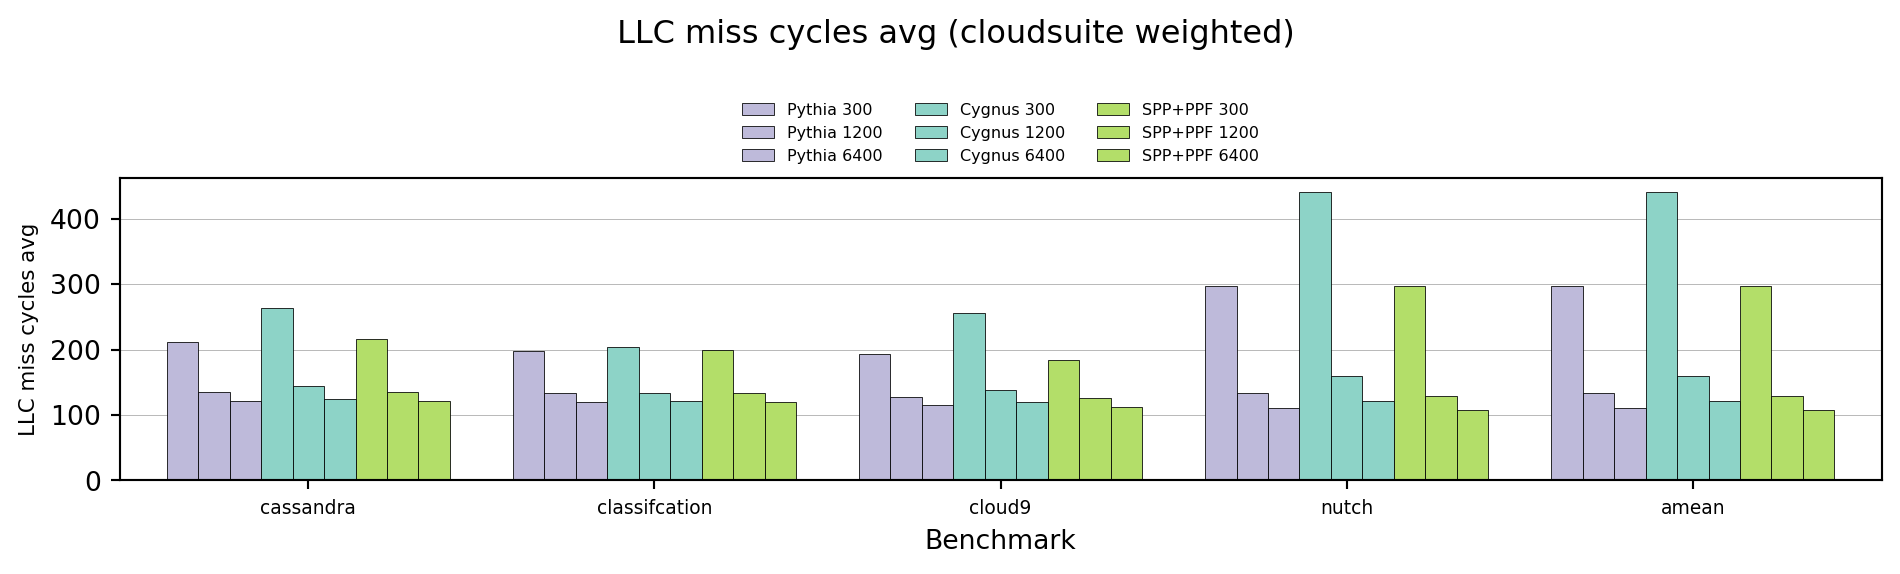

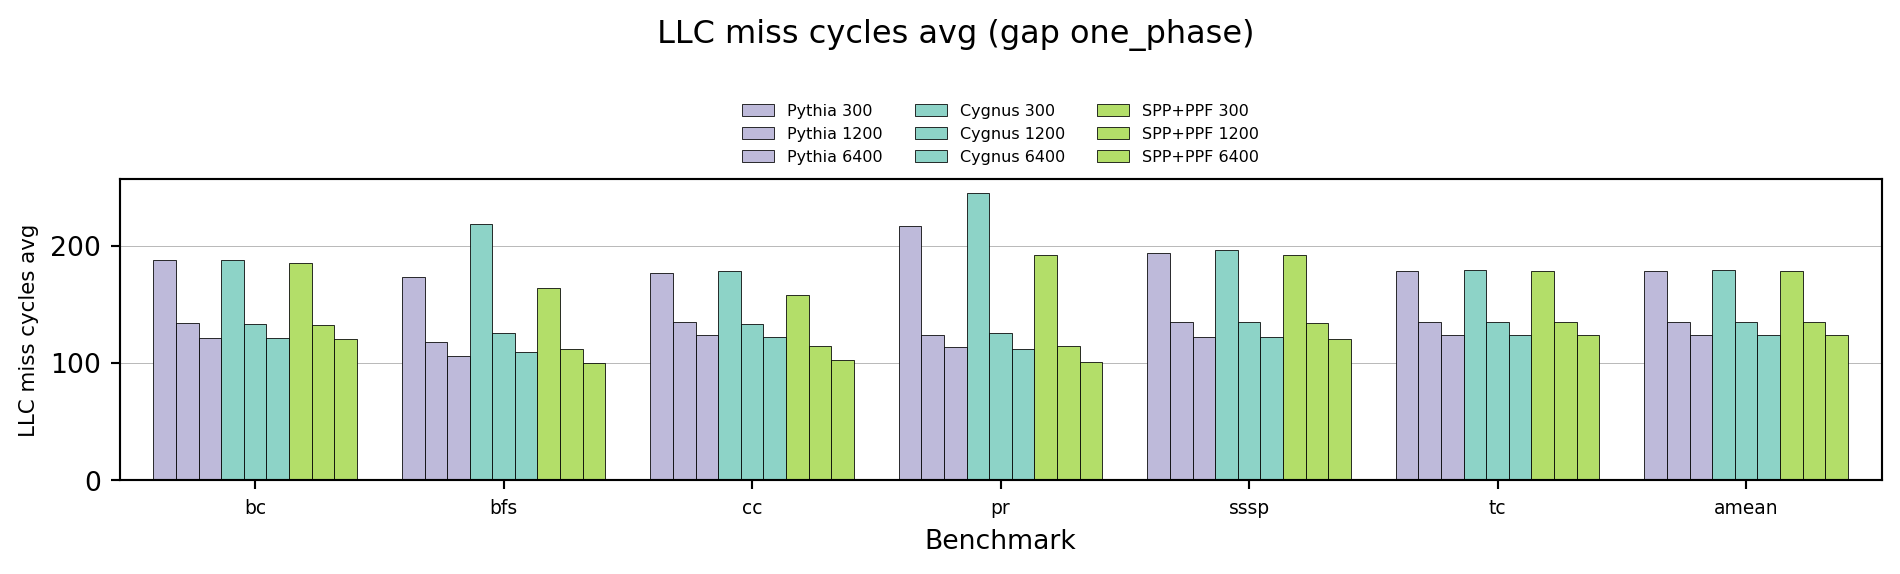

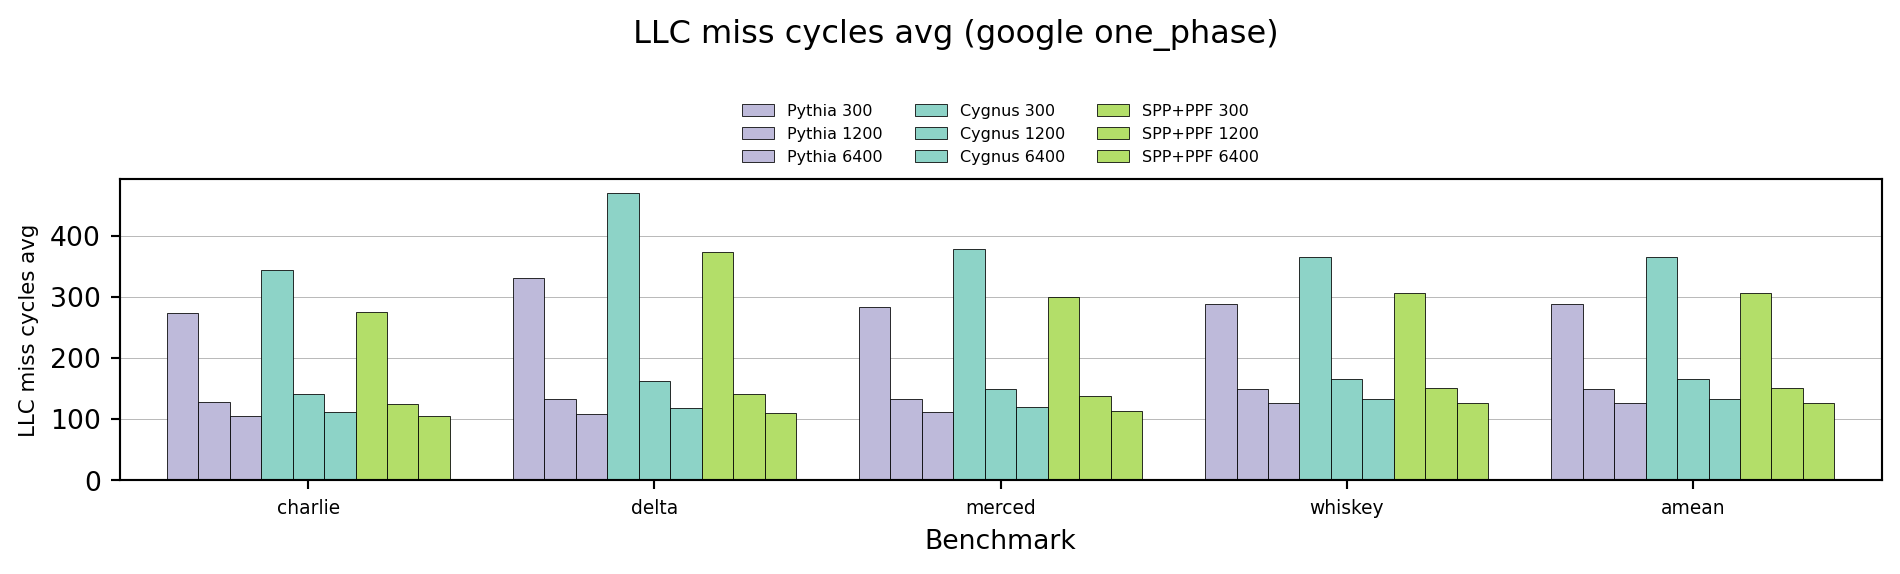

In [29]:
plots.plot_everything(bw_df, suites=suites, metrics=['LLC_miss_cycles_avg'], 
                      colors=bw_colors, legend_kwargs=bw_legend_kwargs,
                      label_kwargs=bw_label_kwargs, 
                      dpi=192, figsize=(10, 3))

# Tables

## 1-core, dynamic degree